In [1]:
# Importing the Keras libraries and packages
from keras.utils import np_utils
from keras.models import Sequential, load_model
from keras.layers import Input, Convolution2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import optimizers

# Importing other necessary libraries
from sklearn.metrics import classification_report,confusion_matrix
from PIL import Image
import matplotlib.pyplot as plt
import multiprocessing as mp
import numpy as np
import h5py, os, itertools, heapq

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

c:\users\default.laptop-2ci68m4p\anaconda3\envs\tensorflow1\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Architecture

In [3]:
# Declaring shape of input images and number of categories to classify
input_shape = (128, 128, 3)
num_classes = 3

model = Sequential()

#convolution layer 1, 2
model.add(Convolution2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Convolution2D(32, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#convolution layer 3, 4
model.add(Convolution2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Convolution2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#convolution layer 5, 6
model.add(Convolution2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Convolution2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#Fully connected layer
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

#model.compile(loss = "binary_crossentropy", optimizer = optimizers.SGD(lr=0.01))
#model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"])
model.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.001),metrics=["accuracy"])


In [4]:
# Viewing model_configuration
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        18496     
__________

### Image preprocessing

In [8]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   rotation_range = 20,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('./dataset_lower/train',
                                                 target_size = (128, 128),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('./dataset_lower/valid',
                                            target_size = (128, 128),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 2345 images belonging to 3 classes.
Found 595 images belonging to 3 classes.


### Callbacks (save weights while training)

In [9]:
# Setting callbacks parameters
checkpointer = ModelCheckpoint(filepath='model2_lower.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)
filename='model2_lower.csv'
csv_log = CSVLogger(filename, separator=',', append=False)

### Training

In [10]:
# Training the model
hist = model.fit_generator(training_set,
                           steps_per_epoch = (2345//32),
                           epochs = 500,
                           validation_data = test_set,
                           validation_steps = (592//32), 
                           workers = 4, 
                           callbacks = [csv_log, checkpointer])

Epoch 1/500
73/73 [==============================] - 11s 150ms/step - loss: 1.6817 - acc: 0.3841 - val_loss: 2.1585 - val_acc: 0.3125

Epoch 00001: val_loss improved from inf to 2.15849, saving model to model2_lower.01-2.16.hdf5
Epoch 2/500
73/73 [==============================] - 8s 105ms/step - loss: 1.3738 - acc: 0.4712 - val_loss: 2.0747 - val_acc: 0.2569

Epoch 00002: val_loss improved from 2.15849 to 2.07468, saving model to model2_lower.02-2.07.hdf5
Epoch 3/500
73/73 [==============================] - 8s 106ms/step - loss: 1.2379 - acc: 0.5054 - val_loss: 2.6892 - val_acc: 0.3021

Epoch 00003: val_loss did not improve from 2.07468
Epoch 4/500
73/73 [==============================] - 8s 105ms/step - loss: 1.2222 - acc: 0.5159 - val_loss: 2.7044 - val_acc: 0.2865

Epoch 00004: val_loss did not improve from 2.07468
Epoch 5/500
73/73 [==============================] - 8s 105ms/step - loss: 1.1216 - acc: 0.5433 - val_loss: 2.2862 - val_acc: 0.2535

Epoch 00005: val_loss did not impro

73/73 [==============================] - 8s 108ms/step - loss: 0.5091 - acc: 0.7722 - val_loss: 3.3455 - val_acc: 0.2101

Epoch 00088: val_loss did not improve from 1.94578
Epoch 89/500
73/73 [==============================] - 8s 112ms/step - loss: 0.5119 - acc: 0.7701 - val_loss: 2.7655 - val_acc: 0.2344

Epoch 00089: val_loss did not improve from 1.94578
Epoch 90/500
73/73 [==============================] - 8s 106ms/step - loss: 0.5026 - acc: 0.7741 - val_loss: 3.6825 - val_acc: 0.1858

Epoch 00090: val_loss did not improve from 1.94578
Epoch 91/500
73/73 [==============================] - 10s 136ms/step - loss: 0.4760 - acc: 0.7953 - val_loss: 3.7472 - val_acc: 0.1997

Epoch 00091: val_loss did not improve from 1.94578
Epoch 92/500
73/73 [==============================] - 8s 109ms/step - loss: 0.4955 - acc: 0.7801 - val_loss: 2.8443 - val_acc: 0.2604

Epoch 00092: val_loss did not improve from 1.94578
Epoch 93/500
73/73 [==============================] - 8s 111ms/step - loss: 0.5067

73/73 [==============================] - 8s 112ms/step - loss: 0.4451 - acc: 0.8031 - val_loss: 4.3922 - val_acc: 0.1701

Epoch 00132: val_loss did not improve from 1.94578
Epoch 133/500
73/73 [==============================] - 9s 124ms/step - loss: 0.4427 - acc: 0.8011 - val_loss: 3.9105 - val_acc: 0.1979

Epoch 00133: val_loss did not improve from 1.94578
Epoch 134/500
73/73 [==============================] - 8s 111ms/step - loss: 0.4418 - acc: 0.7919 - val_loss: 4.1849 - val_acc: 0.2031

Epoch 00134: val_loss did not improve from 1.94578
Epoch 135/500
73/73 [==============================] - 8s 111ms/step - loss: 0.4458 - acc: 0.8131 - val_loss: 3.1193 - val_acc: 0.2865

Epoch 00135: val_loss did not improve from 1.94578
Epoch 136/500
73/73 [==============================] - 8s 112ms/step - loss: 0.4588 - acc: 0.7938 - val_loss: 3.6382 - val_acc: 0.1944

Epoch 00136: val_loss did not improve from 1.94578
Epoch 137/500
73/73 [==============================] - 8s 110ms/step - loss: 0.

73/73 [==============================] - 8s 111ms/step - loss: 0.4201 - acc: 0.8125 - val_loss: 4.1790 - val_acc: 0.2188

Epoch 00176: val_loss did not improve from 1.94578
Epoch 177/500
73/73 [==============================] - 8s 110ms/step - loss: 0.4156 - acc: 0.8323 - val_loss: 4.5903 - val_acc: 0.2031

Epoch 00177: val_loss did not improve from 1.94578
Epoch 178/500
73/73 [==============================] - 8s 110ms/step - loss: 0.4218 - acc: 0.8223 - val_loss: 4.2664 - val_acc: 0.1597

Epoch 00178: val_loss did not improve from 1.94578
Epoch 179/500
73/73 [==============================] - 9s 123ms/step - loss: 0.4166 - acc: 0.8227 - val_loss: 3.7824 - val_acc: 0.1892

Epoch 00179: val_loss did not improve from 1.94578
Epoch 180/500
73/73 [==============================] - 8s 113ms/step - loss: 0.4054 - acc: 0.8233 - val_loss: 4.1288 - val_acc: 0.1476

Epoch 00180: val_loss did not improve from 1.94578
Epoch 181/500
73/73 [==============================] - 8s 109ms/step - loss: 0.


Epoch 00219: val_loss did not improve from 1.94578
Epoch 220/500
73/73 [==============================] - 9s 124ms/step - loss: 0.3953 - acc: 0.8283 - val_loss: 3.2224 - val_acc: 0.3611

Epoch 00220: val_loss did not improve from 1.94578
Epoch 221/500
73/73 [==============================] - 8s 112ms/step - loss: 0.4438 - acc: 0.8095 - val_loss: 4.0631 - val_acc: 0.1632

Epoch 00221: val_loss did not improve from 1.94578
Epoch 222/500
73/73 [==============================] - 8s 107ms/step - loss: 0.3972 - acc: 0.8307 - val_loss: 4.3098 - val_acc: 0.2153

Epoch 00222: val_loss did not improve from 1.94578
Epoch 223/500
73/73 [==============================] - 8s 105ms/step - loss: 0.3863 - acc: 0.8311 - val_loss: 4.0072 - val_acc: 0.1875

Epoch 00223: val_loss did not improve from 1.94578
Epoch 224/500
73/73 [==============================] - 8s 107ms/step - loss: 0.3808 - acc: 0.8283 - val_loss: 4.7122 - val_acc: 0.2240

Epoch 00224: val_loss did not improve from 1.94578
Epoch 225/500

73/73 [==============================] - 8s 111ms/step - loss: 0.3207 - acc: 0.8726 - val_loss: 4.4450 - val_acc: 0.2031

Epoch 00307: val_loss did not improve from 1.94578
Epoch 308/500
73/73 [==============================] - 8s 108ms/step - loss: 0.3397 - acc: 0.8562 - val_loss: 5.3960 - val_acc: 0.1146

Epoch 00308: val_loss did not improve from 1.94578
Epoch 309/500
73/73 [==============================] - 8s 108ms/step - loss: 0.3427 - acc: 0.8576 - val_loss: 3.9905 - val_acc: 0.1858

Epoch 00309: val_loss did not improve from 1.94578
Epoch 310/500
73/73 [==============================] - 9s 118ms/step - loss: 0.3067 - acc: 0.8823 - val_loss: 4.5958 - val_acc: 0.1354

Epoch 00310: val_loss did not improve from 1.94578
Epoch 311/500
73/73 [==============================] - 8s 114ms/step - loss: 0.3516 - acc: 0.8514 - val_loss: 5.4725 - val_acc: 0.1441

Epoch 00311: val_loss did not improve from 1.94578
Epoch 312/500
73/73 [==============================] - 8s 111ms/step - loss: 0.

73/73 [==============================] - 8s 110ms/step - loss: 0.3153 - acc: 0.8673 - val_loss: 4.7778 - val_acc: 0.1580

Epoch 00351: val_loss did not improve from 1.94578
Epoch 352/500
73/73 [==============================] - 8s 109ms/step - loss: 0.3202 - acc: 0.8711 - val_loss: 5.0342 - val_acc: 0.1649

Epoch 00352: val_loss did not improve from 1.94578
Epoch 353/500
73/73 [==============================] - 8s 112ms/step - loss: 0.2967 - acc: 0.8759 - val_loss: 4.6700 - val_acc: 0.1510

Epoch 00353: val_loss did not improve from 1.94578
Epoch 354/500
73/73 [==============================] - 8s 111ms/step - loss: 0.3087 - acc: 0.8750 - val_loss: 6.1027 - val_acc: 0.2240

Epoch 00354: val_loss did not improve from 1.94578
Epoch 355/500
73/73 [==============================] - 8s 111ms/step - loss: 0.3097 - acc: 0.8707 - val_loss: 4.6402 - val_acc: 0.1476

Epoch 00355: val_loss did not improve from 1.94578
Epoch 356/500
73/73 [==============================] - 8s 110ms/step - loss: 0.

73/73 [==============================] - 8s 109ms/step - loss: 0.3025 - acc: 0.8756 - val_loss: 5.4694 - val_acc: 0.1858

Epoch 00395: val_loss did not improve from 1.94578
Epoch 396/500
73/73 [==============================] - 8s 108ms/step - loss: 0.2977 - acc: 0.8805 - val_loss: 5.6988 - val_acc: 0.1337

Epoch 00396: val_loss did not improve from 1.94578
Epoch 397/500
73/73 [==============================] - 9s 124ms/step - loss: 0.2819 - acc: 0.8763 - val_loss: 4.7858 - val_acc: 0.2118

Epoch 00397: val_loss did not improve from 1.94578
Epoch 398/500
73/73 [==============================] - 10s 132ms/step - loss: 0.2798 - acc: 0.8816 - val_loss: 4.8403 - val_acc: 0.1927

Epoch 00398: val_loss did not improve from 1.94578
Epoch 399/500
73/73 [==============================] - 8s 110ms/step - loss: 0.2903 - acc: 0.8823 - val_loss: 5.5209 - val_acc: 0.1337

Epoch 00399: val_loss did not improve from 1.94578
Epoch 400/500
73/73 [==============================] - 8s 108ms/step - loss: 0

73/73 [==============================] - 8s 111ms/step - loss: 0.2614 - acc: 0.8900 - val_loss: 5.3404 - val_acc: 0.1701

Epoch 00439: val_loss did not improve from 1.94578
Epoch 440/500
73/73 [==============================] - 8s 109ms/step - loss: 0.2721 - acc: 0.8859 - val_loss: 5.2769 - val_acc: 0.1840

Epoch 00440: val_loss did not improve from 1.94578
Epoch 441/500
73/73 [==============================] - 8s 110ms/step - loss: 0.2547 - acc: 0.8929 - val_loss: 6.5319 - val_acc: 0.1736

Epoch 00441: val_loss did not improve from 1.94578
Epoch 442/500
73/73 [==============================] - 8s 109ms/step - loss: 0.2772 - acc: 0.8891 - val_loss: 6.0250 - val_acc: 0.1632

Epoch 00442: val_loss did not improve from 1.94578
Epoch 443/500
73/73 [==============================] - 8s 111ms/step - loss: 0.2729 - acc: 0.8782 - val_loss: 5.7078 - val_acc: 0.1649

Epoch 00443: val_loss did not improve from 1.94578
Epoch 444/500
73/73 [==============================] - 8s 108ms/step - loss: 0.

73/73 [==============================] - 8s 109ms/step - loss: 0.2576 - acc: 0.8930 - val_loss: 6.7140 - val_acc: 0.1875

Epoch 00483: val_loss did not improve from 1.94578
Epoch 484/500
73/73 [==============================] - 8s 108ms/step - loss: 0.2546 - acc: 0.8961 - val_loss: 5.3949 - val_acc: 0.1667

Epoch 00484: val_loss did not improve from 1.94578
Epoch 485/500
73/73 [==============================] - 8s 108ms/step - loss: 0.2549 - acc: 0.8985 - val_loss: 6.9626 - val_acc: 0.1649

Epoch 00485: val_loss did not improve from 1.94578
Epoch 486/500
73/73 [==============================] - 8s 111ms/step - loss: 0.2391 - acc: 0.9050 - val_loss: 5.9667 - val_acc: 0.1806

Epoch 00486: val_loss did not improve from 1.94578
Epoch 487/500
73/73 [==============================] - 8s 108ms/step - loss: 0.2554 - acc: 0.8998 - val_loss: 5.3836 - val_acc: 0.1979

Epoch 00487: val_loss did not improve from 1.94578
Epoch 488/500
73/73 [==============================] - 8s 108ms/step - loss: 0.

### Results

Text(0.5,1,'Training & Validation Accuracy')

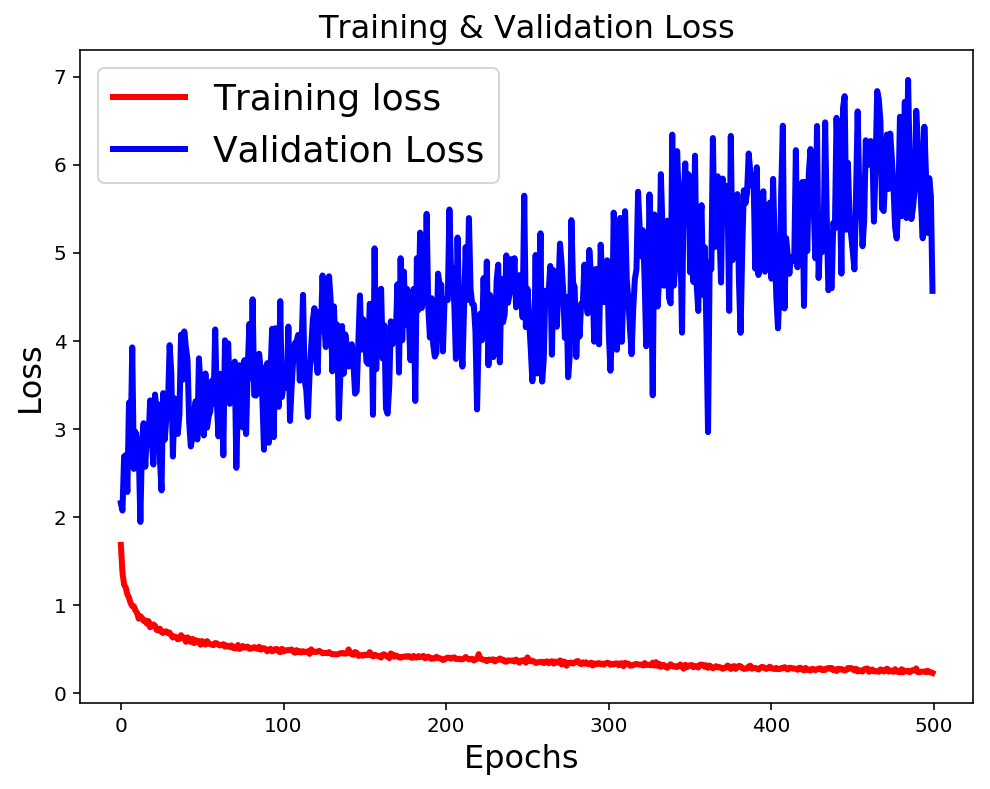

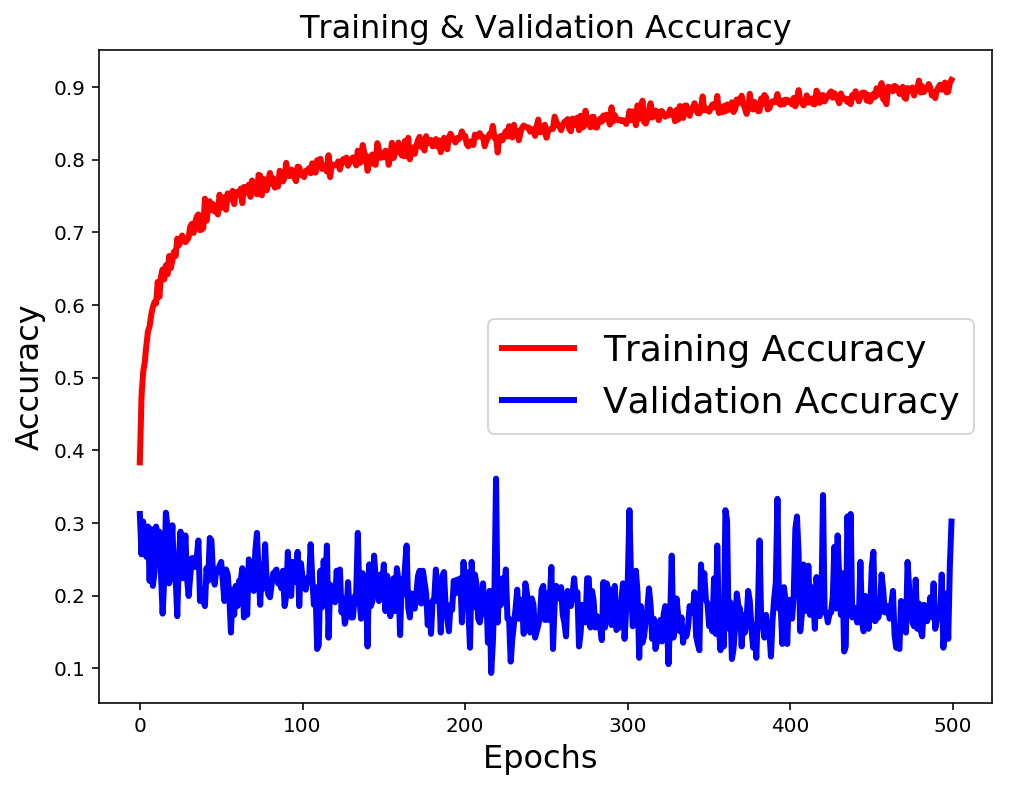

In [11]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(hist.history['loss'],'r',linewidth=3.0)
plt.plot(hist.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Training & Validation Loss',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(hist.history['acc'],'r',linewidth=3.0)
plt.plot(hist.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Training & Validation Accuracy',fontsize=16)

In [21]:
test_path = 'dataset_lower/test'
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size = (128, 128), 
                                                         classes=['jeans','shorts','skirt'],
                                                                   batch_size = 90)

Found 90 images belonging to 3 classes.


In [22]:
test_imgs, test_labels = next(test_batches)
batch_pred = model.predict_generator(test_batches, steps=1)

In [23]:
# Compute confusion matrix
from sklearn.metrics import classification_report,confusion_matrix
cnf_matrix = confusion_matrix(np.argmax(test_labels, axis=1), np.argmax(batch_pred, axis=1))
np.set_printoptions(precision=2)
cnf_matrix

array([[ 0,  0, 30],
       [ 0,  0, 30],
       [ 0,  0, 30]], dtype=int64)

Confusion matrix, without normalization
[[ 0  0 30]
 [ 0  0 30]
 [ 0  0 30]]


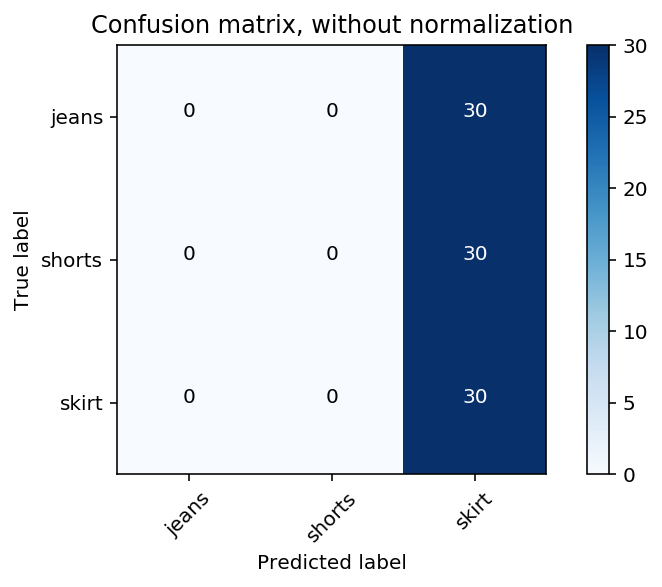

In [24]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['jeans','shorts','skirt'],
                      title='Confusion matrix, without normalization')

In [25]:
classes=['jeans','shorts','skirt']
print(classification_report(np.argmax(test_labels, axis=1), np.argmax(batch_pred, axis=1),target_names=classes))

             precision    recall  f1-score   support

      jeans       0.00      0.00      0.00        30
     shorts       0.00      0.00      0.00        30
      skirt       0.33      1.00      0.50        30

avg / total       0.11      0.33      0.17        90



c:\users\default.laptop-2ci68m4p\anaconda3\envs\tensorflow1\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Conclusion


In [26]:
training_set.class_indices

{'jeans': 0, 'shorts': 1, 'skirt': 2}

In [27]:
test_batches.class_indices

{'jeans': 0, 'shorts': 1, 'skirt': 2}

In [28]:
model.save('model2.h5')